## Predictive Analytics
#### Name : Rajib Ratan Samanta
#### Topic: Predicting of Diabetes and Prediabetes Given Various Health and Lifestyle Factors!

In [2]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN
from collections import Counter
from itertools import cycle
import os

In [3]:
# 1. Load the dataset as a Pandas data frame.
# 2. Display the first ten rows of data.
# Read  US retails sales  data file ('diabetes_012_health_indicators_BRFSS2015.csv') from local:
directory = '/Users/rajibsamanta/Documents/Rajib/College/Sem 7 Winter 2023/Week11/Project' 
# Set the working directory
os.chdir(directory)
print(os.getcwd())

/Users/rajibsamanta/Documents/Rajib/College/Sem 7 Winter 2023/Week11/Project


In [4]:
# Data Loading and Preprocessing

data=pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")
nancount=data.isna().sum().sum()

print(f"There are {nancount} missing values")

There are 0 missing values


In [5]:
data.shape

(253680, 22)

The initial data set has 253,680 rows and 22 columns.

In [6]:
print(f"There are {data.duplicated().sum()} rows containing duplicates.")

There are 23899 rows containing duplicates.


In [7]:
data.drop_duplicates(inplace=True) # Drop duplicates
# Verify duplicated rows were dropped
print(f"The dimensions of the dataframe after removing duplicates are {data.shape}")

The dimensions of the dataframe after removing duplicates are (229781, 22)


In [8]:
data["Diabetes_012"].value_counts(normalize=1)

Diabetes_012
0.0    0.827114
2.0    0.152741
1.0    0.020145
Name: proportion, dtype: float64

This shows the target class proportions. 

82.7% of respondents had no diabetes diagnosis.

15.3% of respondents had diabetes.

2.0% of respondents were pre-diabetic.

We know we have an imbalanced dataset. This will be dealt with later on.

In [9]:
data.head(3) # Observe first few rows

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0


([0, 1, 2], [Text(0, 0, '0.0'), Text(1, 0, '1.0'), Text(2, 0, '2.0')])

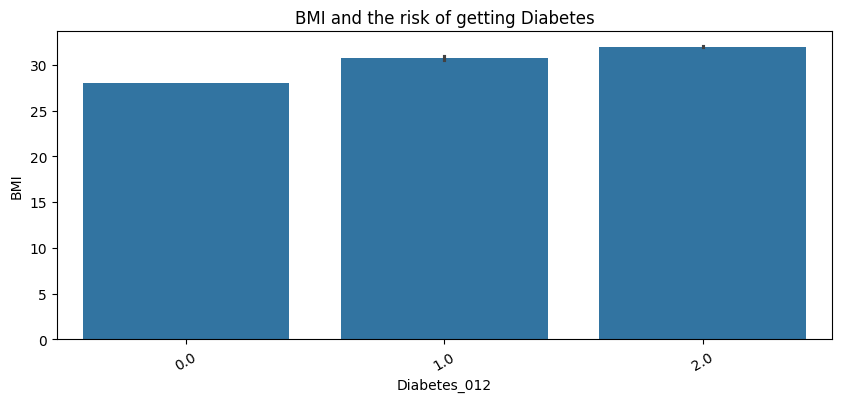

In [10]:
# Now plot different EDA anlsysis graph
plt.figure(figsize=(10,4))
sns.barplot(data,x='Diabetes_012',y='BMI')
plt.title("BMI and the risk of getting Diabetes")
plt.xticks(rotation=30)

The graph above shows that there is a positive relationship between a person's BMI and the risk of getting Diabetes. People whose BMI is lower than 30 have zero risk of diabetes. However, the Diabetes 1 and 2 are prevalent in individuals whose BMI is above 30

Text(0.5, 1.0, 'Cholestrol and the risks of Diabetes.')

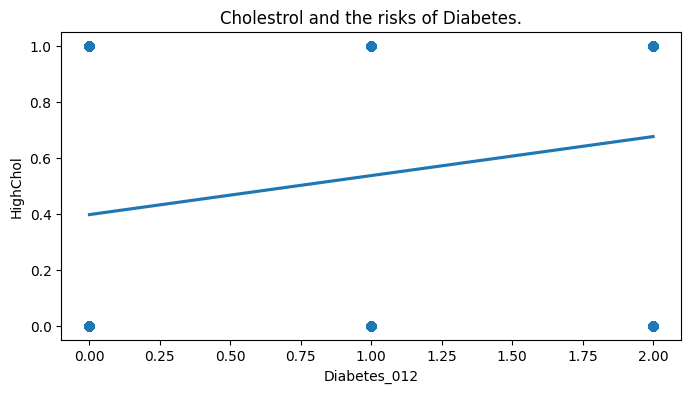

In [11]:
# Relationship of Cholestrol and the risks of Diabetes.
plt.figure(figsize=(8,4))
sns.regplot(data,x='Diabetes_012',y='HighChol')
plt.title("Cholestrol and the risks of Diabetes.")

There is a slight positive relationship between High amaounts of Cholestrol and the risks of Diabetes. People without Diabetes have consumed less cholesterol as opposed to those with diabetes two who have a spike in Cholesterol.

Text(0.5, 1.0, 'Veggies and the risks of Diabetes.')

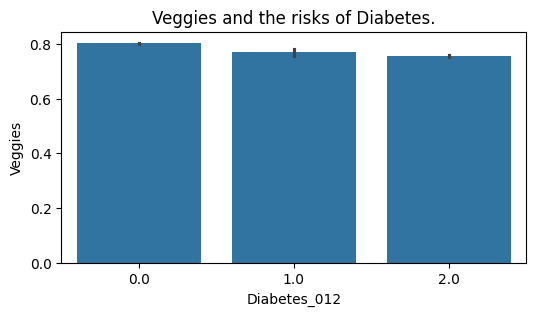

In [12]:
# Relationship of food habits and the risks of Diabetes.
plt.figure(figsize=(6,3))
sns.barplot(x=data['Diabetes_012'],y=data['Veggies'])
plt.title("Veggies and the risks of Diabetes.")


 The above graph shows that good number of people without Diabetes are Veggies.

Text(0.5, 1.0, 'Physical Activity and the risks of Diabetes.')

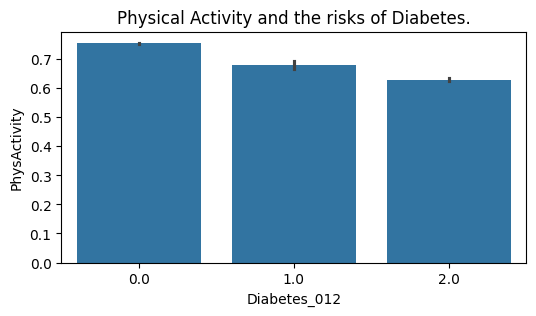

In [13]:
# Relationship of Physical Activity and the risks of Diabetes.
plt.figure(figsize=(6,3))
sns.barplot(x=data['Diabetes_012'],y=data['PhysActivity'])
plt.title("Physical Activity and the risks of Diabetes.")

The graph above shows that diabetes is inversely proportional. People who engage in more physical activities have a lower chance of developing diabetes.

Text(0.5, 1.0, 'Age and the risks of Diabetes.')

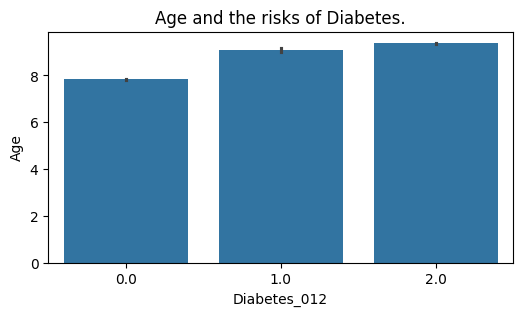

In [14]:
# Relationship of Age and the risks of Diabetes.
plt.figure(figsize=(6,3))
sns.barplot(x=data['Diabetes_012'],y=data['Age'])
plt.title("Age and the risks of Diabetes.")

The likelihood of developing diabetes increases with age.

<Axes: >

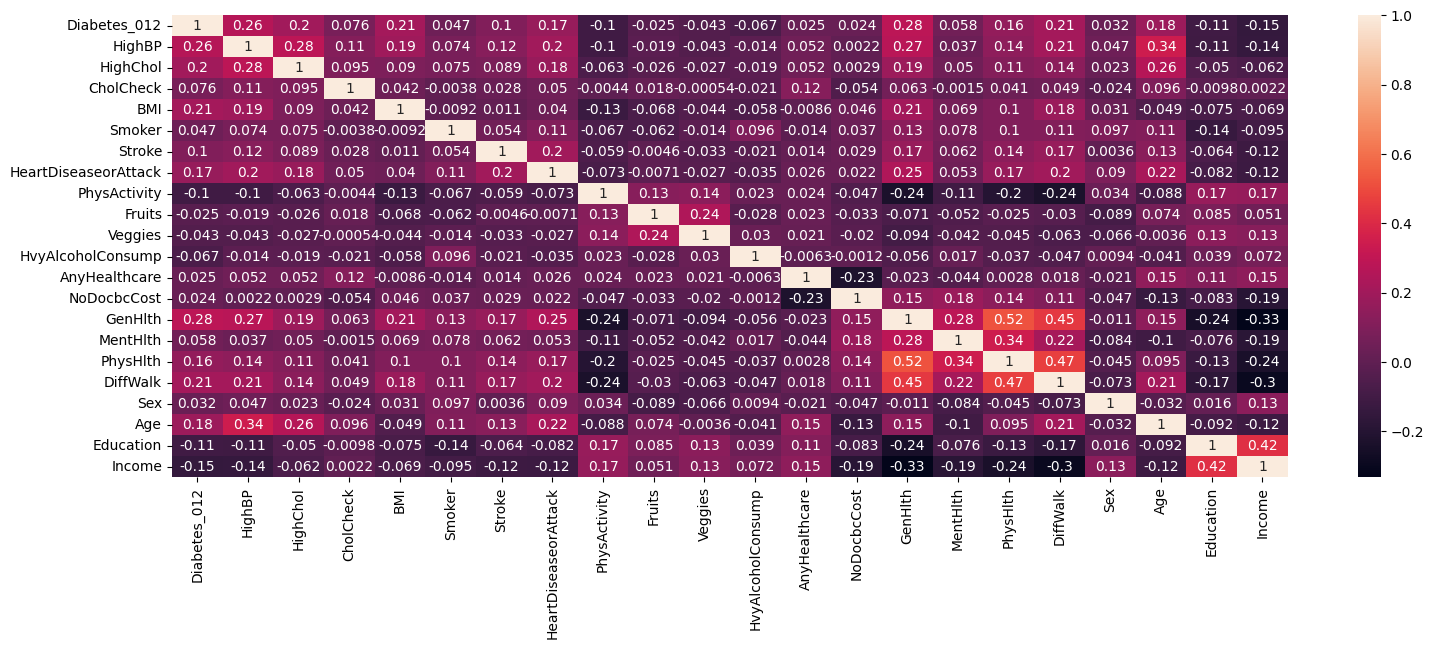

In [15]:
plt.figure(figsize=(18,6)) # Set figure size
sns.heatmap(data.corr(), annot=True) # Produce a correlation heatmap plot

From the correlation heatmap we can see which variables are most strongly correlated.

GenHealth, HighBP, BMI, DiffWalk, HighChol, and Age are fairly strongly correlated.

NoDocbcCost, Fruits, AnyHealthcare, and Sex exhibit weak correlation.

In [16]:
# Set X and y (Predictors and Target)
X = data.drop(['Diabetes_012'], axis=1)
y = data['Diabetes_012']

In [17]:
scaler = StandardScaler() # Initialize a Standard Scaler
scaler.fit(X) # Fit the standard scaler

StandardScaler()

In [18]:
# Transform the features with the fitted standard scaler
scaled_features = scaler.transform(X) 
# Create dataframe with scaled features and original column headers
X = pd.DataFrame(scaled_features,columns=data.columns[1:])
X.head(10) # Observe first 10 rows of scaled features data frame

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.095675,1.124132,0.205356,1.667220,1.071208,-0.216455,-0.339257,-1.658403,-1.258473,0.508092,...,0.238745,-0.319852,2.253111,1.879074,1.141300,2.095383,-0.885023,0.295241,-0.987588,-1.381324
1,-0.912679,-0.889575,-4.869594,-0.543101,1.071208,-0.216455,-0.339257,0.602990,-1.258473,-1.968149,...,-4.188578,3.126450,0.374618,-0.454434,-0.516791,-0.477240,-0.885023,-0.351213,1.026729,-2.337131
2,1.095675,1.124132,0.205356,-0.101037,-0.933526,-0.216455,-0.339257,-1.658403,0.794614,-1.968149,...,0.238745,3.126450,2.253111,3.434746,2.799391,2.095383,-0.885023,0.295241,-0.987588,1.008193
3,1.095675,-0.889575,0.205356,-0.248391,-0.933526,-0.216455,-0.339257,0.602990,0.794614,0.508092,...,0.238745,-0.319852,-0.564629,-0.454434,-0.516791,-0.477240,-0.885023,0.941695,-1.994746,0.052387
4,1.095675,1.124132,0.205356,-0.690456,-0.933526,-0.216455,-0.339257,0.602990,0.794614,0.508092,...,0.238745,-0.319852,-0.564629,-0.065516,-0.516791,-0.477240,-0.885023,0.941695,0.019571,-0.903420
5,1.095675,1.124132,0.205356,-0.543101,1.071208,-0.216455,-0.339257,0.602990,0.794614,0.508092,...,0.238745,-0.319852,-0.564629,-0.454434,-0.295713,-0.477240,1.129914,0.618468,1.026729,1.008193
6,1.095675,-0.889575,0.205356,0.193673,1.071208,-0.216455,-0.339257,-1.658403,-1.258473,-1.968149,...,0.238745,-0.319852,0.374618,-0.454434,1.030760,-0.477240,-0.885023,0.295241,1.026729,0.530290
7,1.095675,1.124132,0.205356,-0.543101,1.071208,-0.216455,-0.339257,0.602990,-1.258473,0.508092,...,0.238745,-0.319852,0.374618,-0.454434,-0.516791,2.095383,-0.885023,0.941695,-0.987588,-0.903420
8,1.095675,1.124132,0.205356,0.193673,1.071208,-0.216455,2.947618,-1.658403,0.794614,0.508092,...,0.238745,-0.319852,2.253111,3.434746,2.799391,2.095383,-0.885023,0.295241,0.019571,-2.337131
9,-0.912679,-0.889575,0.205356,-0.690456,-0.933526,-0.216455,-0.339257,-1.658403,-1.258473,0.508092,...,0.238745,-0.319852,-0.564629,-0.454434,-0.516791,-0.477240,1.129914,-0.027986,-0.987588,-1.381324


In [19]:
# Initialize RandomOverSampler or SMOTE
oversampler = RandomOverSampler(random_state=42, sampling_strategy='not majority')
#oversampler = SMOTE(random_state=42)
#oversampler = SMOTEENN(random_state=42)


# Perform oversampling on the data
X_oversampled, y_oversampled = oversampler.fit_resample(X, y)

# Check class distribution after oversampling
print("Class distribution after oversampling:", Counter(y_oversampled))

Class distribution after oversampling: Counter({0.0: 190055, 2.0: 190055, 1.0: 190055})


In [20]:
# Split oversampled data into test and train sets

X_over_train,X_over_test,y_over_train,y_over_test=train_test_split(X_oversampled,y_oversampled,test_size=0.2,random_state=42)

In [21]:
# Build and evaluate Decision Tree model

dt = DecisionTreeClassifier(random_state=42) # Initialize Decision Tree model
dt = dt.fit(X_over_train, y_over_train) # Train Decision Tree model
DecisionTree_over_predicted=dt.predict(X_over_test) # Use trained model to predict

# Generate classification report
report = classification_report(y_over_test,DecisionTree_over_predicted)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.82      0.90     37783
         1.0       0.97      1.00      0.99     38258
         2.0       0.86      0.99      0.92     37992

    accuracy                           0.94    114033
   macro avg       0.94      0.94      0.93    114033
weighted avg       0.94      0.94      0.94    114033



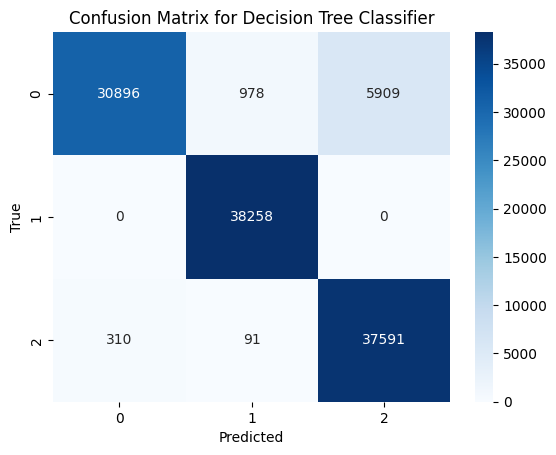

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_over_test,DecisionTree_over_predicted)

sns.heatmap(cm, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

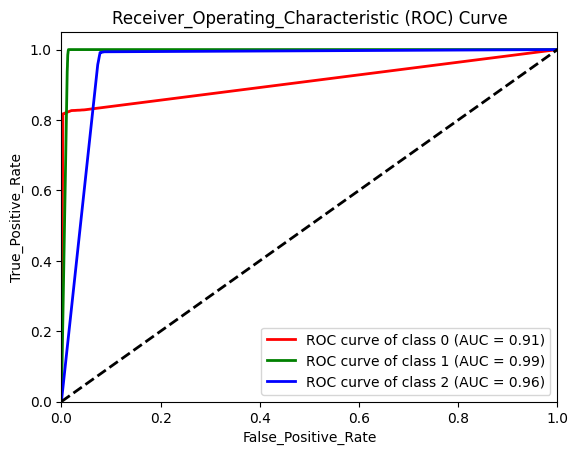

In [23]:
"""The following code is used to generate ROC Curve"""

# Predict probabilities on test set
pred_y_score = dt.predict_proba(X_over_test)

# Binarize the labels
y_test_binary = label_binarize(y_over_test, classes=[0, 1, 2])
number_classes = y_test_binary.shape[1]

# Compute ROC curve and AUC 
false_pos = dict()
true_pos = dict()
roc_auc = dict()
for i in range(number_classes):
    false_pos[i], true_pos[i], _ = roc_curve(y_test_binary[:, i], pred_y_score[:, i])
    roc_auc[i] = auc(false_pos[i], true_pos[i])

# Plot ROC curve 
colors = cycle(['red', 'green', 'blue'])
for i, color in zip(range(number_classes), colors):
    plt.plot(false_pos[i], true_pos[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False_Positive_Rate')
plt.ylabel('True_Positive_Rate')
plt.title('Receiver_Operating_Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [24]:
"""This code is a randomized search cross validation used to determine
the optimal hyperparameters. This code takes a long time to run and so
has been commented out. The hyperparameters produced have been used."""


# Define hyperparameters for random search
# param_distributions = {
#    'max_depth': np.arange(3, 13),  # Random integers from 3 to 10
#    'learning_rate': [0.01, 0.1, 0.5],  # Fixed list of learning rates
#    'min_child_weight': np.arange(1, 11),  # Random integers from 1 to 10
#    'gamma': [0, 0.1, 0.3],  # Fixed list of gamma values
#}

# Define custom scorer
# scorer = make_scorer(accuracy_score)

# Initialize XGBoost classifier
# XGB_over = XGBClassifier()

# Perform random search with cross-validation
# XGB_over_random_search = RandomizedSearchCV(
#    estimator=XGB_over,
#    param_distributions=param_distributions,
#    scoring=scorer,
#    cv=4,
#    n_iter=25,  # Number of random parameter settings that are sampled
#    # verbose=3,
#    random_state=42,  # Random state for reproducibility
#    n_jobs=-1 ) # Utilize all available CPU cores


# Fit the random search to the data
# XGB_over_random_search.fit(X_over_train, y_over_train)


'This code is a randomized search cross validation used to determine\nthe optimal hyperparameters. This code takes a long time to run and so\nhas been commented out. The hyperparameters produced have been used.'

In [25]:
# This code has been commented out but can be commented back in if above is run
# XGB_over_random_search.best_params_

# When run it produces {'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.5, 'gamma': 0.1}

In [26]:
# Initialize the XGBClassifier with hyperparameters derived from CV search

XGB_weighted = XGBClassifier(learning_rate=0.5,max_depth=12,min_child_weight=1,gamma=0.1)

In [27]:
# Fit XGBClassifier model on training data

XGB_weighted.fit(X_over_train, y_over_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [28]:
# Perform predictions using trained model

XGB_w_predicted=XGB_weighted.predict(X_over_test) 

In [29]:
# Generate classification report
report = classification_report(y_over_test, XGB_w_predicted)
print(report)


              precision    recall  f1-score   support

         0.0       0.94      0.82      0.87     37783
         1.0       0.97      1.00      0.99     38258
         2.0       0.85      0.94      0.89     37992

    accuracy                           0.92    114033
   macro avg       0.92      0.92      0.92    114033
weighted avg       0.92      0.92      0.92    114033



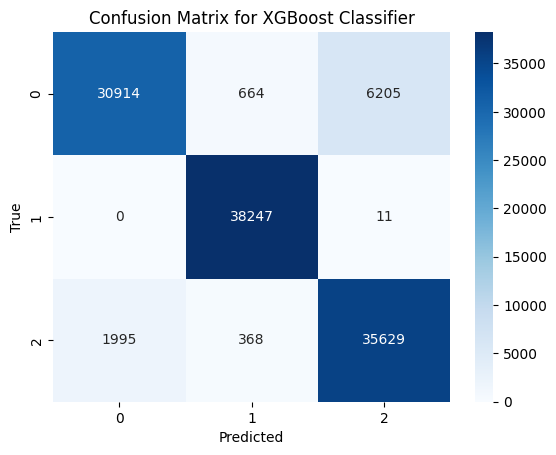

In [30]:
cmat = confusion_matrix(y_over_test, XGB_w_predicted)
sns.heatmap(cmat, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()


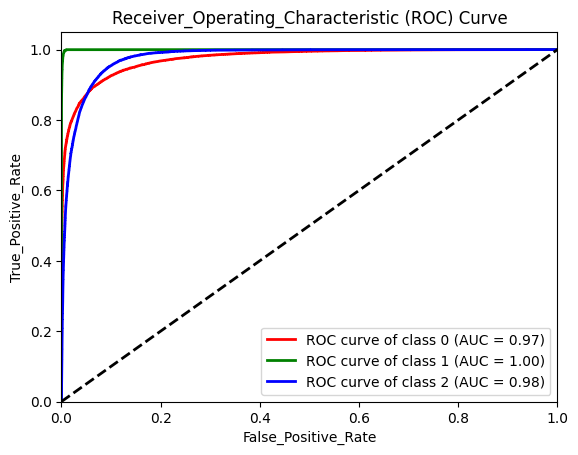

In [31]:
"""The following code is used to generate ROC Curve"""

# Predict probabilities on test set
pred_y_score_xgb = XGB_weighted.predict_proba(X_over_test)

# Binarize the labels
y_test_binary = label_binarize(y_over_test, classes=[0, 1, 2])
number_classes = y_test_binary.shape[1]

# Compute ROC curve and AUC 
false_pos = dict()
true_pos = dict()
roc_auc = dict()
for i in range(number_classes):
    false_pos[i], true_pos[i], _ = roc_curve(y_test_binary[:, i], pred_y_score_xgb[:, i])
    roc_auc[i] = auc(false_pos[i], true_pos[i])

# Plot ROC curve 
colors = cycle(['red', 'green', 'blue'])
for i, color in zip(range(number_classes), colors):
    plt.plot(false_pos[i], true_pos[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False_Positive_Rate')
plt.ylabel('True_Positive_Rate')
plt.title('Receiver_Operating_Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [32]:
"""Here we try ensemble models to see if we can gain a marked improvement.
We commented out Gradient Boosting model because it produced such poor results."""

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train Random Forest model
rf_model.fit(X_over_train, y_over_train)

# Make predictions on the test set
rf_predictions = rf_model.predict(X_over_test)

# Evaluate Random Forest model
rf_report = classification_report(y_over_test, rf_predictions)

# Initialize Gradient Boosting model
# gb_model = GradientBoostingClassifier(random_state=42)

# Train Gradient Boosting model
# gb_model.fit(X_over_train, y_over_train)

# Make predictions on the test set
# gb_predictions = gb_model.predict(X_over_test)

# Evaluate Gradient Boosting model
# gb_report = classification_report(y_over_test, gb_predictions)

print("Random Forest Classification Report:")
print(rf_report)

# print("\nGradient Boosting Classification Report:")
# print(gb_report)


Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94     37783
         1.0       0.99      1.00      1.00     38258
         2.0       0.90      0.99      0.95     37992

    accuracy                           0.96    114033
   macro avg       0.96      0.96      0.96    114033
weighted avg       0.96      0.96      0.96    114033



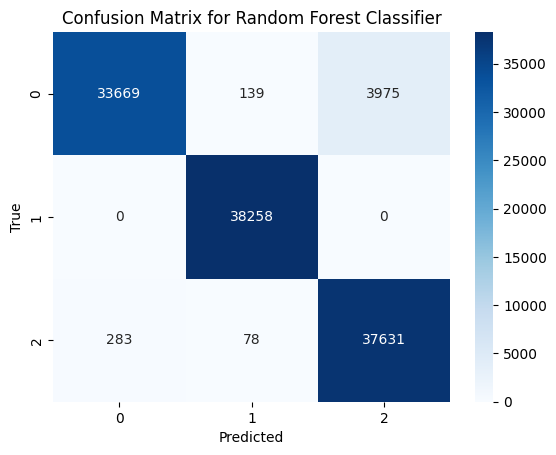

In [33]:
cmatrix = confusion_matrix(y_over_test, rf_predictions)
sns.heatmap(cmatrix, annot=True, fmt='g', cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

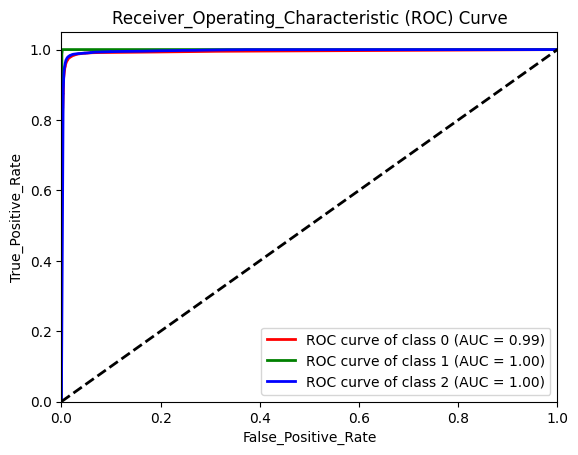

In [34]:
"""The following code is used to generate ROC Curve"""

# Predict probabilities on test set
pred_y_score_rf = rf_model.predict_proba(X_over_test)

# Binarize the labels
y_test_binary = label_binarize(y_over_test, classes=[0, 1, 2])
number_classes = y_test_binary.shape[1]

# Compute ROC curve and AUC 
false_pos = dict()
true_pos = dict()
roc_auc = dict()
for i in range(number_classes):
    false_pos[i], true_pos[i], _ = roc_curve(y_test_binary[:, i], pred_y_score_rf[:, i])
    roc_auc[i] = auc(false_pos[i], true_pos[i])

# Plot ROC curve 
colors = cycle(['red', 'green', 'blue'])
for i, color in zip(range(number_classes), colors):
    plt.plot(false_pos[i], true_pos[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False_Positive_Rate')
plt.ylabel('True_Positive_Rate')
plt.title('Receiver_Operating_Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()